In [5]:
import sys
import os
from pathlib import Path
# This appends the directory one level up (the root of your project) to the sys.path.
# Modify the path depending on the location of modules you want to import.
sys.path.append(os.path.abspath('../../'))

from config.config_managers import DashboardConfigManager
from dataManager import DataManager
from dash import Dash
import pandas as pd
import plotly.express as px
from abc import ABC, abstractmethod
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [10]:
class Visualization(ABC):
    def __init__(self, data, mappings):
        self.data = data
        self.tag_mapping = mappings['tag_mapping']
        self.dataset_mapping = mappings['dataset_mapping']

    @abstractmethod
    def prepare_data(self):
        pass

    @abstractmethod
    def visualize(self):
        pass

    def replace_mappings(self, data):
        data = self.replace_tags(data)
        data = self.replace_model(data)
        # data['Model'] = data['Model'].replace(self.dataset_mapping)
        return data
    
    def replace_tags(self, data):
        data['Tag'] = data['Tag'].replace(self.tag_mapping)
        return data
    
    def replace_model(self, data):
        data['Model'] = data['Model'].replace(self.dataset_mapping)
        return data
    
    def replace_columns_and_index(self, data):
        return data.rename(columns=self.tag_mapping, index=self.tag_mapping)

        
    
    

mappings = {
    'tag_mapping': {'B-PERS': 'B-PER', 'I-PERS': 'I-PER',},
    'dataset_mapping': {'ANERCorp_CamelLab_arabertv02': 'AraBERTv02', 'conll2003_bert': 'BERT'}
}

class ReportBarChart(Visualization):
    def prepare_data(self):
        report_data = []
        for model_name, data_content in self.data.items():
            token_report = data_content.token_report
            token_report['Model'] = model_name
            report_data.append(pd.concat([
                token_report, 
            ]))
        report_df = pd.concat(report_data)
        report_df = report_df[~report_df['Tag'].isin(['accuracy/micro', 'macro', 'weighted'])]    
        
        return self.replace_mappings(report_df)

    def visualize(self):
        token_report_data = self.prepare_data()
        melted_df = token_report_data.melt(
        id_vars=["Tag", "Support", "Model"], 
        value_vars=["Precision", "Recall"], 
        var_name="Metric", 
        value_name="Value"
        )
        
        # Round the values for better readability
        melted_df['Value'] = melted_df['Value'].round(3)
        # Create the bar chart using Plotly Express
        fig = px.bar(
            melted_df, 
            x="Tag", 
            y="Value", 
            color="Metric",
            facet_row="Model",  # Separate rows for each model
            title="Breakdown of Precision and Recall Scores by Entity Tag, Categorized by Model",
            labels={"Value": "Score", 'Tag': 'Entity Tag'},
            barmode="group",
            template="plotly_white",
            facet_row_spacing=0.15,  # Adjust to a higher value for more space
            text='Value'  # Display the Value on top of each bar
        )
        fig.update_layout(
            width=1200,
            height=400,
            # margin=dict(t=50, l=50, r=50, b=50)
        )
        
        # Show the figure
        fig.show()
    
    def visualize_f1(self):
        token_report_data = self.prepare_data()
        token_report_data['F1'] = token_report_data['F1'].round(3)
        fig = px.bar(token_report_data,
                    x="Tag",
                    y="F1",
                    color="Model",
                    title="Breakdown of F1 Score Per Model",
                    barmode='group',
                    template="plotly_white",
                    text='F1',  # Display the actual Count on top of each bar
                    )
        
        fig.update_layout(
            width=1200,
            height=400,
            # margin=dict(t=50, l=50, r=50, b=50)
        )
        fig.update_xaxes(title_text="Entity Tag")
        fig.show()
        
        
    def visualize_support(self):
        token_report_data = self.prepare_data()
        token_report_data = token_report_data[token_report_data['Tag'] !='O']
        fig = px.bar(token_report_data,
                    x="Tag", 
                    y="Support",
                    color="Model",
                    title="Breakdown of the Number of Examples Per Model in the Test Split",
                    barmode='group',
                    template="plotly_white",
                    # facet_row_spacing=0.1,  # Adjusted spacing
                    facet_col_spacing=0.08,
                    text='Support',  # Display the actual Count on top of each bar
                    )
        fig.update_layout(
            width=1200,
            height=400,
            # margin=dict(t=50, l=50, r=50, b=50)
        )
        fig.update_xaxes(title_text="Entity Tag")
        fig.show()

class ConfusionBarChart(Visualization):
    def prepare_data(self):
        matrices = []
        for model_name, data_content in self.data.items():
            token_matrix = pd.DataFrame(data_content.token_confusion_matrix['confusion_matrix']).T 
            token_matrix['Model'] = model_name
            matrices.append(pd.concat([
                token_matrix, 
            ]))
        matrix_df = pd.concat(matrices)
        matrix_df.reset_index(inplace=True)
        matrix_df.rename(columns={'index': 'Tag'}, inplace=True)
        matrix_data = self.replace_mappings(matrix_df)
        
                
        grouped = matrix_data.groupby(['Tag', 'Model']).sum()
        grouped['Total'] = grouped['TP'] + grouped['FP'] + grouped['FN']
        
        matrix_data = matrix_data.merge(grouped['Total'], on=['Tag', 'Model'], how='left')
        
        matrix_data['TP_Count'] = matrix_data['TP']
        matrix_data['FP_Count'] = matrix_data['FP']
        matrix_data['FN_Count'] = matrix_data['FN']
        
        matrix_data['TP'] = matrix_data['TP'] / matrix_data['Total']
        matrix_data['FP'] = matrix_data['FP'] / matrix_data['Total']
        matrix_data['FN'] = matrix_data['FN'] / matrix_data['Total']
        
        confusion_scaled_df = matrix_data.melt(id_vars=["Tag", "Model"], value_vars=["TP", "FP", "FN"], var_name="Metric", value_name="Scale")
        confusion_count_df = matrix_data.melt(id_vars=["Tag", "Model"], value_vars=["TP_Count", "FP_Count", "FN_Count"], var_name="Metric", value_name="Count")
        confusion_count_df['Metric'] = confusion_count_df['Metric'].str.replace('_Count', '')
        confusion_data = confusion_scaled_df.merge(confusion_count_df, on=["Tag", "Model", "Metric"])
        return confusion_data

    def visualize(self):
        confusion_df = self.prepare_data()
        print(confusion_df)
        
        fig = px.bar(confusion_df,
                    x="Tag", y="Scale", color="Metric",
                    facet_row="Model",
                    title="Breakdown of Confusion Matrix Components: by Entity Tag, Categorized by Model",
                    labels={"Scale": "Scaled Counts"},
                    barmode='group',
                    template="plotly_white",
                    facet_row_spacing=0.1,  # Adjusted spacing
                    text='Count',  # Display the actual Count on top of each bar
                    category_orders={"Tag": ["B-LOC", "B-PER", "B-ORG", "B-MISC", "I-LOC", "I-ORG", "I-PER", "I-MISC"]}

                    )
        
        fig.show()



class ConfusionHeatmap(Visualization):
    def prepare_data(self):
        matrices = []
        for model_name, data_content in self.data.items():
            token_matrix = pd.DataFrame(data_content.token_confusion_matrix['confusion_matrix']).T 
            token_matrix['Model'] = model_name
            matrices.append(pd.concat([
                token_matrix, 
            ]))
        matrix_df = pd.concat(matrices)
        matrix_df.reset_index(inplace=True)
        matrix_df.rename(columns={'index': 'Tag'}, inplace=True)
        return self.replace_mappings(matrix_df)
        

    def visualize(self):
        token_matrix = self.prepare_data()
        token_matrix = token_matrix[token_matrix['Tag'] !='O']
        confusion_df = token_matrix.melt(
            id_vars=['Tag', 'Model'], 
            value_vars=['TP', 'FP', 'FN'], 
            var_name='Metric', 
            value_name='Count'
        )
        
        unique_models = confusion_df['Model'].unique()  # Only two models
        max_value = confusion_df['Count'].max()  # Get the max value for consistent color scaling

        # Create a subplot for each model
        fig = make_subplots(
            rows=len(unique_models), cols=1,  # Rows for models, single column
            subplot_titles=[f"{model}" for model in unique_models],
            shared_yaxes=True, horizontal_spacing=0.5, vertical_spacing=0.1
        )

        for idx, model in enumerate(unique_models):
            # Filter data for the current model
            filtered_data = confusion_df[confusion_df['Model'] == model]
            
            # Prepare heatmap data
            heatmap_data = filtered_data.pivot_table(index='Metric', columns='Tag', values='Count', fill_value=0)
            text_data = heatmap_data.astype(int)  # Convert values to integers for display

            # Add heatmap trace for the current model
            fig.add_trace(
                go.Heatmap(
                    z=heatmap_data.values,  # Heatmap values
                    x=heatmap_data.columns,  # Columns (Tags)
                    y=heatmap_data.index,  # Rows (Metrics)
                    colorscale='RdBu_r',
                    coloraxis="coloraxis",  # Unified color axis
                    text=text_data,  # Add text annotations
                    texttemplate="%{text}",  # Use the text values directly
                    hovertemplate="Metric: %{y}<br>Tag: %{x}<br>Count: %{text}<extra></extra>",
                ),
                row=idx + 1, col=1  # Stack rows for models
            )
        
        # Update layout with unified color axis and title
        fig.update_layout(
            coloraxis=dict(colorscale='RdBu_r', cmin=0, cmax=max_value, colorbar=dict(title="Counts")),
            title_text="Confusion Matrix Heatmap Categorized by Model",
            template="plotly_white",
            
            height=400 * len(unique_models),  # Adjust height dynamically based on the number of models
            width=900,  # Adjust the width if necessary
        )

        # Show the figure
        fig.show()
        

class ErrorTypeHeatmap(Visualization):
    def prepare_data(self):
        matrix_data = []
        # Step 1: Collect general error data
        for model_name, data_content in self.data.items():
            token_confusion = data_content.token_misclassifications
                
            # Annotate with Model and Scheme
            token_confusion['Model'] = model_name
            token_confusion = self.replace_columns_and_index(token_confusion)
            matrix_data.append(token_confusion)
        
        # Step 2: Combine and process data
        matrix_df = pd.concat(matrix_data)
        matrix_df.reset_index(inplace=True)
        matrix_df.rename(columns={'index': 'Tag'}, inplace=True)
        matrix_df = self.replace_model(matrix_df)
        return matrix_df

    def visualize(self):
        token_misclassifications = self.prepare_data()
        
        # Group by 'Model'
        models = token_misclassifications['Model'].unique()

        # Create subplots for heatmaps
        fig = make_subplots(
            rows=1,
            cols=len(models),
            subplot_titles=models,
            horizontal_spacing=0.2
        )
        max_value = token_misclassifications.drop(columns=['Tag', 'Model']).values.max()

        # Iterate over each model and create a heatmap
        for i, model in enumerate(models, start=1):
            model_df = token_misclassifications[token_misclassifications['Model'] == model].set_index('Tag')
            model_df = model_df.drop(columns='Model')  # Drop the Model column
            fig.add_trace(
                go.Heatmap(
                    z=model_df.values,
                    x=model_df.columns,
                    y=model_df.index,
                    colorscale='RdBu_r',
                    coloraxis="coloraxis",  # Unified color axis
                    text=model_df.values,
                    texttemplate="%{text}",
                    hovertemplate="True: %{y}<br>Predict: %{x}<br>Count: %{text}<extra></extra>",  # Updated hover labels
                ),
                row=1, col=i
            )
        for idx in range(1, len(models) + 1):
            fig.update_yaxes(title_text="True Labels", row=1, col=idx)
            fig.update_xaxes(title_text="Predicted Labels", row=1, col=idx)

        # Update layout
        fig.update_layout(
            coloraxis=dict(colorscale='RdBu_r', cmin=0, cmax=max_value, colorbar=dict(title="Counts")),
            title="Error Heatmap Across Entity Tags for AraBERTv02 and BERT",
            template="plotly_white",
            width=1200,
            height=600,
       
        )

        fig.show()
    
    def visualize_table(self):
        """
        Generates tables showing raw counts and percentages for each error type, 
        categorized by Scheme and Model.
        """
        # Step 1: Prepare the data
        token_misclassifications = self.prepare_data()
        print(token_misclassifications.to_string(index=False)) 

In [7]:
CONFIG_PATH = Path("/Users/ay227/Desktop/Final-Year/Thesis-Experiments/Online-Dashboard-Phase/dashboard-config.yaml")
config_manager = DashboardConfigManager(CONFIG_PATH)
dev_config = config_manager.development_config    

app = Dash(__name__, suppress_callback_exceptions=True)

app_config = config_manager.app_config
server = app.server  # Flask server instance for caching
variants_data = None

data_manager = DataManager(config_manager, server)
dash_data = data_manager.load_data()

2025-03-11 08:01:54 - WARNING - Resolved path does not exist, checking alternative paths: /Users/ay227/Desktop/Final-Year/Thesis-Experiments/Online-Dashboard-Phase/deformer-dashboard/notebooks/analysis/My Drive
2025-03-11 08:01:54 - INFO - Found Google Drive directory for account ahmed.younes.sam@gmail.com: /Users/ay227/Library/CloudStorage/GoogleDrive-ahmed.younes.sam@gmail.com
2025-03-11 08:01:54 - INFO - Loading Dashboard Data from  /Users/ay227/Library/CloudStorage/GoogleDrive-ahmed.younes.sam@gmail.com/My Drive/Final Year Experiments/Thesis-Experiments/Experiments/BaseLineExperiment/ANERCorp_CamelLab_arabertv02


  0%|          | 0/18 [00:00<?, ?it/s]

2025-03-11 08:02:00 - WARNING - Resolved path does not exist, checking alternative paths: /Users/ay227/Desktop/Final-Year/Thesis-Experiments/Online-Dashboard-Phase/deformer-dashboard/notebooks/analysis/My Drive
2025-03-11 08:02:00 - INFO - Found Google Drive directory for account ahmed.younes.sam@gmail.com: /Users/ay227/Library/CloudStorage/GoogleDrive-ahmed.younes.sam@gmail.com
2025-03-11 08:02:00 - INFO - Loading Dashboard Data from  /Users/ay227/Library/CloudStorage/GoogleDrive-ahmed.younes.sam@gmail.com/My Drive/Final Year Experiments/Thesis-Experiments/Experiments/BaseLineExperiment/conll2003_bert


  0%|          | 0/18 [00:00<?, ?it/s]

In [8]:
tr_df = dash_data['ANERCorp_CamelLab_arabertv02'].train_data

In [15]:
report_data = []
for data_name, data_content in dash_data.items():
	token_report = data_content.token_report 
	tr_data = data_content.train_data
	token_report['Model'] = data_name
	tr_support = tr_data[tr_data['Labels']!= -100]['True Labels'].value_counts().reset_index().rename(columns = {'True Labels': 'Tag', 'count': 'Train Support'})
	tr = token_report.merge(tr_support, on='Tag')
	report_data.append(pd.concat([
		tr, 
	]))
report_df = pd.concat(report_data)
report_df = report_df[~report_df['Tag'].isin(['accuracy/micro', 'macro', 'weighted'])]    
tag_mapping = {
    'B-PERS': 'B-PER',
    'I-PERS': 'I-PER'
}

dataset_mapping = {
    'ANERCorp_CamelLab_arabertv02': 'AraBERTv02',
    'conll2003_bert': 'BERT'
}

report_df['Tag'] = report_df['Tag'].replace(tag_mapping)
report_df['Model'] = report_df['Model'].replace(dataset_mapping)
report_df


token_report_data = report_df[report_df['Tag'] !='O']
fig = px.bar(token_report_data,
			x="Tag", 
			y="Train Support",
			color="Model",
			title="Breakdown of the Number of Examples Per Model in the Train Split",
			barmode='group',
			template="plotly_white",
			# facet_row_spacing=0.1,  # Adjusted spacing
			facet_col_spacing=0.08,
			text='Train Support',  # Display the actual Count on top of each bar
			)
fig.update_layout(
	width=1200,
	height=400,
	# margin=dict(t=50, l=50, r=50, b=50)
)
fig.update_xaxes(title_text="Entity Tag")
fig.show()

In [16]:
# Confusion matrix heatmap example
report_bar = ReportBarChart(dash_data, mappings)
report_bar.visualize_support()

In [17]:
# Confusion matrix heatmap example
report_bar = ReportBarChart(dash_data, mappings)
report_bar.visualize_f1()

In [18]:
# Confusion matrix heatmap example
report_bar = ReportBarChart(dash_data, mappings)
report_bar.visualize()

In [19]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Prepare data for Pearson and Spearman correlations
metrics = ["Precision", "Recall"]
pearson_data = []
spearman_data = []
data = report_df[report_df["Tag"] != "O"]  # Exclude "O" tag for analysis

for model in data["Model"].unique():
    model_data = data[data["Model"] == model]
    for metric in metrics:
        # Pearson correlation
        test_corr_pearson = model_data[["Support", metric]].corr().iloc[0, 1]
        train_corr_pearson = model_data[["Train Support", metric]].corr().iloc[0, 1]
        pearson_data.append({"Metric": metric, "Model": model, "Train": train_corr_pearson, "Test": test_corr_pearson})
        
        # Spearman correlation
        test_corr_spearman = model_data[["Support", metric]].corr(method="spearman").iloc[0, 1]
        train_corr_spearman = model_data[["Train Support", metric]].corr(method="spearman").iloc[0, 1]
        spearman_data.append({"Metric": metric, "Model": model, "Train": train_corr_spearman, "Test": test_corr_spearman})

# Create DataFrames for Pearson and Spearman
pearson_df = pd.DataFrame(pearson_data)
spearman_df = pd.DataFrame(spearman_data)

# Pivot data for heatmap format
pearson_train_heatmap = pearson_df.pivot(index="Metric", columns="Model", values="Train")
pearson_test_heatmap = pearson_df.pivot(index="Metric", columns="Model", values="Test")
spearman_train_heatmap = spearman_df.pivot(index="Metric", columns="Model", values="Train")
spearman_test_heatmap = spearman_df.pivot(index="Metric", columns="Model", values="Test")

# Create subplots for Pearson and Spearman
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=("Pearson Train Correlation", "Pearson Test Correlation", 
                    "Spearman Train Correlation", "Spearman Test Correlation"),
    horizontal_spacing=0.2,
    vertical_spacing=0.1,
    # shared_xaxes=True,
    # shared_yaxes=True,
)

# Add Pearson Train heatmap
fig.add_trace(
    go.Heatmap(
        z=pearson_train_heatmap.values,
        x=pearson_train_heatmap.columns,
        y=pearson_train_heatmap.index,
        text=pearson_train_heatmap.values.round(3),
        texttemplate="%{text}",
        hovertemplate="Metric: %{y}<br>Model: %{x}<br>Correlation: %{z}<extra></extra>",
        colorscale="RdBu_r",
        zmin=-1,
        zmax=1,
    ),
    row=1, col=1,
)

# Add Pearson Test heatmap
fig.add_trace(
    go.Heatmap(
        z=pearson_test_heatmap.values,
        x=pearson_test_heatmap.columns,
        y=pearson_test_heatmap.index,
        text=pearson_test_heatmap.values.round(3),
        texttemplate="%{text}",
        hovertemplate="Metric: %{y}<br>Model: %{x}<br>Correlation: %{z}<extra></extra>",
        colorscale="RdBu_r",
        zmin=-1,
        zmax=1,
    ),
    row=1, col=2,
)

# Add Spearman Train heatmap
fig.add_trace(
    go.Heatmap(
        z=spearman_train_heatmap.values,
        x=spearman_train_heatmap.columns,
        y=spearman_train_heatmap.index,
        text=spearman_train_heatmap.values.round(3),
        texttemplate="%{text}",
        hovertemplate="Metric: %{y}<br>Model: %{x}<br>Correlation: %{z}<extra></extra>",
        colorscale="RdBu_r",
        zmin=-1,
        zmax=1,
    ),
    row=2, col=1,
)

# Add Spearman Test heatmap
fig.add_trace(
    go.Heatmap(
        z=spearman_test_heatmap.values,
        x=spearman_test_heatmap.columns,
        y=spearman_test_heatmap.index,
        text=spearman_test_heatmap.values.round(3),
        texttemplate="%{text}",
        hovertemplate="Metric: %{y}<br>Model: %{x}<br>Correlation: %{z}<extra></extra>",
        colorscale="RdBu_r",
        zmin=-1,
        zmax=1,
    ),
    row=2, col=2,
)

# Update layout
fig.update_layout(
    title="Pearson & Spearman Correlation Heatmaps for Precision and Recall Across Models",
    template="plotly_white",
    height=800,
    width=1000,
    coloraxis=dict(colorbar=dict(title="Correlation")),
    margin=dict(t=80, l=50, r=50, b=50),  # Adjust margins for better spacing
)

fig.show()


In [20]:
print(data)

      Tag  Precision  Recall      F1  Support       Model  Train Support
0   B-LOC     0.9056  0.9476  0.9261      668  AraBERTv02           3772
1  B-MISC     0.8238  0.6766  0.7430      235  AraBERTv02            887
2   B-ORG     0.8237  0.7889  0.8059      450  AraBERTv02           1576
3   B-PER     0.8955  0.8788  0.8871      858  AraBERTv02           2719
4   I-LOC     0.8095  0.8193  0.8144       83  AraBERTv02            525
5  I-MISC     0.8193  0.4121  0.5484      165  AraBERTv02            375
6   I-ORG     0.8024  0.7236  0.7610      275  AraBERTv02           1115
7   I-PER     0.9188  0.9002  0.9094      641  AraBERTv02           2202
0   B-LOC     0.9287  0.9371  0.9329     1668        BERT           7140
1  B-MISC     0.8296  0.8390  0.8343      702        BERT           3438
2   B-ORG     0.9082  0.9169  0.9125     1661        BERT           6321
3   B-PER     0.9665  0.9647  0.9656     1617        BERT           6600
4   I-LOC     0.8495  0.9222  0.8843      257      

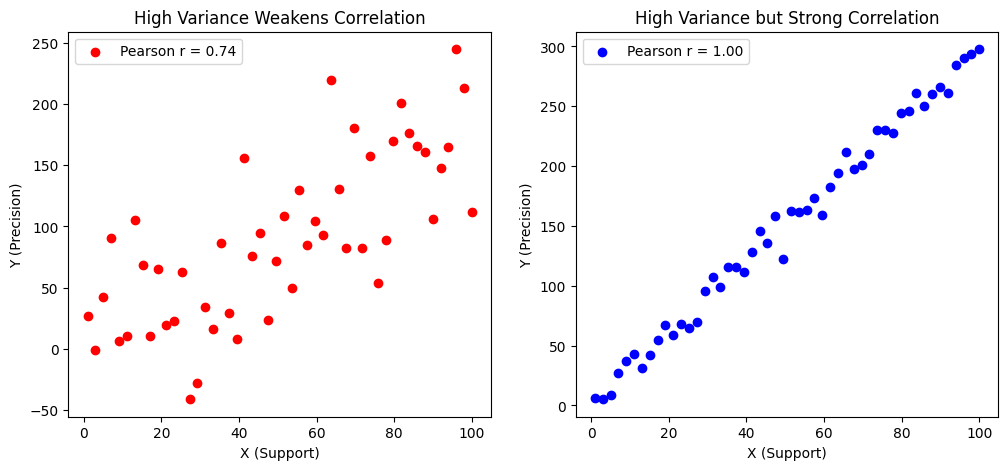

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Case 1: High variance weakens correlation (random noise)
np.random.seed(42)
X1 = np.linspace(1, 100, 50)  # Increasing trend
Y1 = 2 * X1 + np.random.normal(0, 50, 50)  # High variance noise
correlation1, _ = pearsonr(X1, Y1)

# Case 2: High variance but strong correlation (proportional increase)
X2 = np.linspace(1, 100, 50)
Y2 = 3 * X2 + np.random.normal(0, 10, 50)  # Variance, but structured
correlation2, _ = pearsonr(X2, Y2)

# Plot both cases
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].scatter(X1, Y1, color='red', label=f"Pearson r = {correlation1:.2f}")
ax[0].set_title("High Variance Weakens Correlation")
ax[0].set_xlabel("X (Support)")
ax[0].set_ylabel("Y (Precision)")
ax[0].legend()

ax[1].scatter(X2, Y2, color='blue', label=f"Pearson r = {correlation2:.2f}")
ax[1].set_title("High Variance but Strong Correlation")
ax[1].set_xlabel("X (Support)")
ax[1].set_ylabel("Y (Precision)")
ax[1].legend()

plt.show()

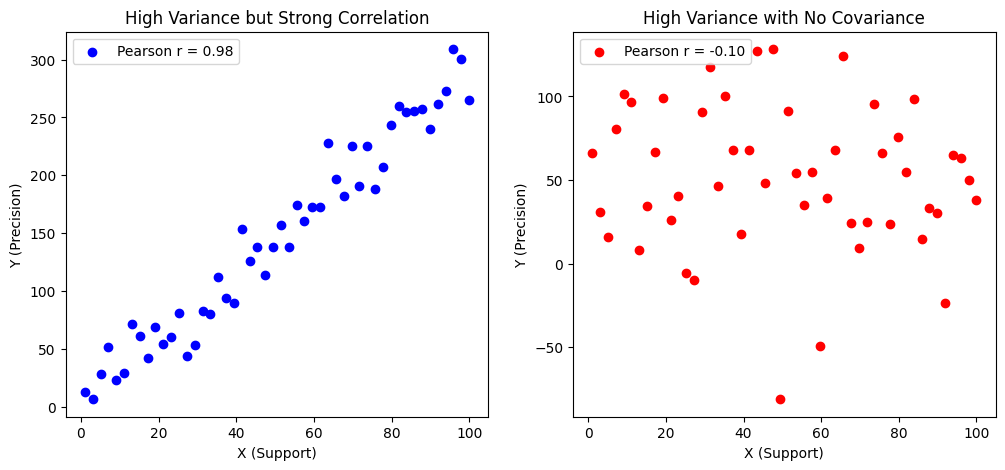

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Case 1: High variance but strong correlation
np.random.seed(42)
X1 = np.linspace(1, 100, 50)  # Support values
Y1 = 3 * X1 + np.random.normal(0, 20, 50)  # High variance but proportional to X
correlation1, _ = pearsonr(X1, Y1)

# Case 2: High variance weakens correlation (random noise added)
Y2 = np.random.normal(0, 50, 50) + 50  # Completely random fluctuations
correlation2, _ = pearsonr(X1, Y2)

# Plot both cases
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].scatter(X1, Y1, color='blue', label=f"Pearson r = {correlation1:.2f}")
ax[0].set_title("High Variance but Strong Correlation")
ax[0].set_xlabel("X (Support)")
ax[0].set_ylabel("Y (Precision)")
ax[0].legend()

ax[1].scatter(X1, Y2, color='red', label=f"Pearson r = {correlation2:.2f}")
ax[1].set_title("High Variance with No Covariance")
ax[1].set_xlabel("X (Support)")
ax[1].set_ylabel("Y (Precision)")
ax[1].legend()

plt.show()


In [23]:
import pandas as pd
import plotly.express as px

# Filter out the 'O' tag
data = report_df[report_df["Tag"] != "O"]

# Melt the DataFrame for plotting
melted_df = data.melt(
    id_vars=["Tag", "Model", "Train Support", "Support"],
    value_vars=["Precision", "Recall"],
    var_name="Metric",
    value_name="Value"
)

# Create separate columns for Train and Test support
melted_train = melted_df.copy()
melted_train["Support Type"] = "Train"
melted_train["Support Value"] = melted_train["Train Support"]

melted_test = melted_df.copy()
melted_test["Support Type"] = "Test"
melted_test["Support Value"] = melted_test["Support"]

# Combine Train and Test data
combined_df = pd.concat([melted_train, melted_test])

# Scatter plot with Train and Test as colors
fig = px.scatter(
    combined_df,
    x="Support Value",
    y="Value",
    color="Support Type",  # Color by Train or Test
    facet_col="Metric",
    facet_row="Model",
    trendline="ols",  # Add trendline (linear regression here)
    facet_row_spacing=0.1,  # Adjusted spacing
    facet_col_spacing=0.03,
    hover_data=["Tag"],
    title="Scatter Plot of Train and Test Support vs Metrics Across Models",
    labels={
        "Support Value": "Support",
        "Value": "Metric Value",
        "Metric": "Metric",
        "Support Type": "Support Type",
    },
    template="plotly_white"
)

# Update layout for better readability
fig.update_layout(
    width=1000,
    height=600,
    xaxis_title="Support",
    yaxis_title="Metric Value",
    legend_title="Support Type",
    # margin=dict(t=50, l=50, r=50, b=50)
)

fig.show()


In [24]:
import pandas as pd
import plotly.express as px
color_map = {
            "B-LOC": "darkgreen",
            "B-PERS": "deepskyblue",
            "B-PER": "deepskyblue",
            "B-ORG": "darkcyan",
            "B-MISC": "palevioletred",
            "I-LOC": "yellowgreen",
            "I-PERS": "lightblue",
            "I-PER": "lightblue",
            "I-ORG": "cyan",
            "I-MISC": "violet",
            "O": "saddlebrown",
        }
# Filter out the 'O' tag
data = report_df[report_df["Tag"] != "O"]

# Melt the DataFrame for plotting
melted_df = data.melt(
    id_vars=["Tag", "Model", "Train Support", "Support"],
    value_vars=["Precision", "Recall"],
    var_name="Metric",
    value_name="Value"
)

# Create separate columns for Train and Test support
melted_train = melted_df.copy()
melted_train["Split"] = "Train"
melted_train["Support Value"] = melted_train["Train Support"]

melted_test = melted_df.copy()
melted_test["Split"] = "Test"
melted_test["Support Value"] = melted_test["Support"]

# Combine Train and Test data
combined_df = pd.concat([melted_train, melted_test])

# Compute mean support and metric per facet (Model, Metric, Split)
facet_means = combined_df.groupby(["Model", "Metric", "Split"]).agg(
    Mean_Support=("Support Value", "mean"),
    Mean_Metric=("Value", "mean"),
    Std_Support=("Support Value", "std"),  # Compute standard deviation
    Std_Metric=("Value", "std"),  # Compute standard deviation
    Max_Support=("Support Value", "max"),  # To detect spread
    Min_Support=("Support Value", "min"),
    Max_Metric=("Value", "max"),
    Min_Metric=("Value", "min")
).reset_index()

# **Compute Support Spread**
facet_means["Support_Spread"] = facet_means["Max_Support"] - facet_means["Min_Support"]


# Function to generate a separate plot for each Model
def create_facet_plot(model_name):
    df_subset = combined_df[combined_df["Model"] == model_name]
    fig = px.scatter(
        df_subset,
        x="Support Value",
        y="Value",
        color="Tag",  # Color by Train/Test
        facet_col="Metric",  # Separate Precision & Recall
        facet_row="Split",  # Separate Train & Test in rows
        trendline="ols",
        facet_row_spacing=0.1,
        facet_col_spacing=0.03,
        hover_data=["Tag"],
        title=f"The Relationship Between Support and Precision/Recall for {model_name} Across Train and Test Splits ",
        labels={
            "Support Value": "Support",
            "Value": "Metric Value",
            "Split": "Split"
        },
        template="plotly_white",
        color_discrete_map=color_map
    )

    # Add facet-specific mean lines with dynamic text positioning
    for _, row in facet_means[facet_means["Model"] == model_name].iterrows():
        # metric, split, mean_support, mean_metric = row["Metric"], row["Split"], row["Mean_Support"], row["Mean_Metric"]
        metric, split, mean_support, mean_metric, std_support, std_metric = row["Metric"], row["Split"], row["Mean_Support"], row["Mean_Metric"], row["Std_Support"], row["Std_Metric"]
        # max_support, min_support, max_metric, min_metric = row["Max_Support"], row["Min_Support"], row["Max_Metric"], row["Min_Metric"]

        # Find correct row and column indices
        row_index = list(facet_means["Split"].unique()).index(split) + 1
        col_index = list(facet_means["Metric"].unique()).index(metric) + 1

        # # Decide annotation position based on data spread
        # support_text_x = max_support * 0.95 if mean_support < (max_support + min_support) / 2 else min_support * 1.05
        # metric_text_y = max_metric * 0.90 if mean_metric < (max_metric + min_metric) / 2 else min_metric * 1.10

        # Add vertical mean line for Support
        fig.add_vline(
            x=mean_support,
            line_dash="dash",
            line_color="gray",
            opacity=0.5,
            row=row_index,
            col=col_index
        )

        # Add horizontal mean line for Metric
        fig.add_hline(
            y=mean_metric,
            line_dash="dash",
            line_color="gray",
            opacity=0.5,
            row=row_index,
            col=col_index
        )
        
       # **Fix annotation placement (prevent overlap)**
        fig.add_annotation(
            x=0.05,  # Left-aligned for better visibility
            y=0.05,  # Added space between text
            xref="paper",  # Fix position relative to subplot
            yref="paper",
            text=(
                f"<b>Mean Support:</b> {mean_support:.1f}<br>"
                f"<b>Support Std Dev:</b> {std_support:.1f}<br>"
                f"<b>Mean Metric:</b> {mean_metric:.2f}<br>"
                f"<b>Metric Std Dev:</b> {std_metric:.2f}"
            ),  
            showarrow=False,
            xanchor="left",
            yanchor="bottom",
            font=dict(size=10, color="gray"),
            row=row_index,
            col=col_index
        )

        # # Add **dynamically placed** annotations
        # fig.add_annotation(
        #     x=support_text_x,  # Position dynamically based on spread
        #     y=mean_metric,
        #     text=f"Mean Support: {mean_support:.1f}",
        #     showarrow=False,
        #     xanchor="left" if mean_support < (max_support + min_support) / 2 else "right",
        #     yanchor="bottom",
        #     font=dict(size=10, color="gray"),
        #     row=row_index,
        #     col=col_index
        # )

        # fig.add_annotation(
        #     x=mean_support,
        #     y=metric_text_y,  # Position dynamically based on spread
        #     text=f"Mean Metric: {mean_metric:.2f}",
        #     showarrow=False,
        #     xanchor="left",
        #     yanchor="top" if mean_metric < (max_metric + min_metric) / 2 else "bottom",
        #     font=dict(size=10, color="gray"),
        #     row=row_index,
        #     col=col_index
        # )

    # Update layout for better readability
    fig.update_layout(
        width=1000,
        height=600,
        xaxis_title="Support",
        yaxis_title="Metric Value",
        legend_title="Split",
        # xaxis=dict(showgrid=False),
        # yaxis=dict(showgrid=False)
    )

    fig.show()

# Generate separate plots for each model
for model in combined_df["Model"].unique():
    create_facet_plot(model)


In [25]:
def calculate_pearson_contributions_with_summary(df, x_col, y_col, group_col="Split"):
    """
    Calculate covariance and variance contributions for each data point in the Pearson correlation equation,
    ensuring means are computed within each split.
    
    Parameters:
    - df: DataFrame containing the data.
    - x_col: Column name for the x variable (Support).
    - y_col: Column name for the y variable (Precision).
    - group_col: Column name to group by before computing means (e.g., Train vs Test Split).

    Returns:
    - DataFrame with covariance contributions and corrected variance contributions.
    """

    # Compute split-specific means
    means = df.groupby(group_col)[[x_col, y_col]].mean().rename(columns={x_col: "X Mean", y_col: "Y Mean"})
    
    # Print model averages
    print("Model Averages:")
    model_means = df.groupby("Model")[[x_col, y_col]].mean()
    print(model_means)

    # Merge split-specific means back to the main dataframe
    df = df.merge(means, on=group_col)

    # Compute deviations within each split
    df["X Deviation"] = df[x_col] - df["X Mean"]
    df["Y Deviation"] = df[y_col] - df["Y Mean"]

    # Compute standard deviations per split
    stds = df.groupby(group_col)[[x_col, y_col]].std(ddof=0).rename(columns={x_col: "X Std", y_col: "Y Std"})
    df = df.merge(stds, on=group_col)

    # Compute Pearson correlation components within each split
    df["Covariance Contribution"] = df["X Deviation"] * df["Y Deviation"] / len(df)
    df["Standardized Covariance Contribution"] = df["Covariance Contribution"] / (df["X Std"] * df["Y Std"])

    return df[[group_col, "Tag", x_col, y_col, "X Deviation", "Y Deviation", "Covariance Contribution",
               "Standardized Covariance Contribution"]]

# Apply the function with split-specific means
pearson_contributions_fixed = calculate_pearson_contributions_with_summary(data.copy(), "Support", "Precision", group_col="Model")
pearson_contributions_fixed


Model Averages:
             Support  Precision
Model                          
AraBERTv02   421.875   0.849825
BERT        1014.000   0.881725


,Model,Tag,Support,Precision,X Deviation,Y Deviation,Covariance Contribution,Standardized Covariance Contribution
0,AraBERTv02,B-LOC,668,0.9056,246.125,0.055775,0.857976,0.073776
1,AraBERTv02,B-MISC,235,0.8238,-186.875,-0.026025,0.303964,0.026137
2,AraBERTv02,B-ORG,450,0.8237,28.125,-0.026125,-0.045923,-0.003949
3,AraBERTv02,B-PER,858,0.8955,436.125,0.045675,1.245001,0.107056
4,AraBERTv02,I-LOC,83,0.8095,-338.875,-0.040325,0.854071,0.073440
5,AraBERTv02,I-MISC,165,0.8193,-256.875,-0.030525,0.490069,0.042140
6,AraBERTv02,I-ORG,275,0.8024,-146.875,-0.047425,0.435347,0.037435
7,AraBERTv02,I-PER,641,0.9188,219.125,0.068975,0.944634,0.081228
8,BERT,B-LOC,1668,0.9287,654.000,0.046975,1.920103,0.038273
9,BERT,B-MISC,702,0.8296,-312.000,-0.052125,1.016437,0.020261


In [26]:
pearson_contributions_fixed = calculate_pearson_contributions_with_summary(data.copy(), "Train Support", "Precision", group_col="Model")
pearson_contributions_fixed


Model Averages:
            Train Support  Precision
Model                               
AraBERTv02       1646.375   0.849825
BERT             4255.375   0.881725


,Model,Tag,Train Support,Precision,X Deviation,Y Deviation,Covariance Contribution,Standardized Covariance Contribution
0,AraBERTv02,B-LOC,3772,0.9056,2125.625,0.055775,7.409796,0.149784
1,AraBERTv02,B-MISC,887,0.8238,-759.375,-0.026025,1.235171,0.024968
2,AraBERTv02,B-ORG,1576,0.8237,-70.375,-0.026125,0.114909,0.002323
3,AraBERTv02,B-PER,2719,0.8955,1072.625,0.045675,3.062009,0.061896
4,AraBERTv02,I-LOC,525,0.8095,-1121.375,-0.040325,2.826215,0.057130
5,AraBERTv02,I-MISC,375,0.8193,-1271.375,-0.030525,2.425545,0.049031
6,AraBERTv02,I-ORG,1115,0.8024,-531.375,-0.047425,1.575029,0.031838
7,AraBERTv02,I-PER,2202,0.9188,555.625,0.068975,2.395265,0.048419
8,BERT,B-LOC,7140,0.9287,2884.625,0.046975,8.469079,0.043699
9,BERT,B-MISC,3438,0.8296,-817.375,-0.052125,2.662854,0.013740


In [27]:
import pandas as pd

# Example data: Support and Precision for two scenarios

# Case 1: Perfect proportional scaling (should give high Pearson correlation)
data_proportional = pd.DataFrame({
    "Tag": ["A", "B", "C", "D", "E"],
    "Support": [100, 200, 300, 400, 500],
    "Precision": [0.5, 0.6, 0.7, 0.8, 0.9]  # Scales proportionally with Support
})

# Case 2: Inconsistent scaling (should give lower Pearson correlation)
data_inconsistent = pd.DataFrame({
    "Tag": ["A", "B", "C", "D", "E"],
    "Support": [100, 200, 300, 400, 500],
    "Precision": [0.5, 0.62, 0.8, 0.90, 0.91]  # Does not scale perfectly
})

# Compute Pearson correlation for both cases
pearson_proportional = data_proportional["Support"].corr(data_proportional["Precision"])
pearson_inconsistent = data_inconsistent["Support"].corr(data_inconsistent["Precision"])

# Compute covariance to show its impact
covariance_proportional = data_proportional["Support"].cov(data_proportional["Precision"])
covariance_inconsistent = data_inconsistent["Support"].cov(data_inconsistent["Precision"])

# Compute standard deviations to check normalization impact
std_support_prop = data_proportional["Support"].std()
std_precision_prop = data_proportional["Precision"].std()
std_support_incon = data_inconsistent["Support"].std()
std_precision_incon = data_inconsistent["Precision"].std()

# Store results for display
results_df = pd.DataFrame({
    "Case": ["Proportional Scaling", "Inconsistent Scaling"],
    "Pearson Correlation": [pearson_proportional, pearson_inconsistent],
    "Covariance": [covariance_proportional, covariance_inconsistent],
    "Support Std Dev": [std_support_prop, std_support_incon],
    "Precision Std Dev": [std_precision_prop, std_precision_incon]
})

results_df


# Step-by-step calculation of Covariance and Pearson for both cases

import numpy as np

# Define support and precision values for both cases
support = np.array([100, 200, 300, 400, 500])

# Perfect Proportionality Case
precision_proportional = np.array([0.5, 0.6, 0.7, 0.8, 0.9])

# Inconsistent Scaling Case
precision_inconsistent = np.array([0.5, 0.62, 0.8, 0.9, 0.91])

# Compute means
mean_support = np.mean(support)
mean_precision_prop = np.mean(precision_proportional)
mean_precision_incon = np.mean(precision_inconsistent)

# Compute deviations from mean
dev_support = support - mean_support
dev_precision_prop = precision_proportional - mean_precision_prop
dev_precision_incon = precision_inconsistent - mean_precision_incon

# Compute covariance manually
cov_prop = np.sum(dev_support * dev_precision_prop) / (len(support) - 1)
cov_incon = np.sum(dev_support * dev_precision_incon) / (len(support) - 1)

# Compute standard deviations
std_support = np.std(support, ddof=1)  # ddof=1 for sample standard deviation
std_precision_prop = np.std(precision_proportional, ddof=1)
std_precision_incon = np.std(precision_inconsistent, ddof=1)

# Compute Pearson correlation manually
pearson_prop = cov_prop / (std_support * std_precision_prop)
pearson_incon = cov_incon / (std_support * std_precision_incon)

# Store results for display
results_manual = pd.DataFrame({
    "Case": ["Proportional Scaling", "Inconsistent Scaling"],
    "Mean Support": [mean_support, mean_support],
    "Mean Precision": [mean_precision_prop, mean_precision_incon],
    "Covariance": [cov_prop, cov_incon],
    "Std Dev Support": [std_support, std_support],
    "Std Dev Precision": [std_precision_prop, std_precision_incon],
    "Pearson Correlation": [pearson_prop, pearson_incon]
})

# Display the numerical breakdown
results_manual


,Case,Mean Support,Mean Precision,Covariance,Std Dev Support,Std Dev Precision,Pearson Correlation
0,Proportional Scaling,300.0,0.700,25.0,158.113883,0.158114,1.000000
1,Inconsistent Scaling,300.0,0.746,27.5,158.113883,0.180222,0.965061


In [28]:
import pandas as pd
from scipy.stats import rankdata

def calculate_spearman_contributions_by_model(df, x_col, y_col):
    """
    Calculate contributions to Spearman correlation for each data point within each model,
    including rank differences and squared differences.
    
    Parameters:
    - df: DataFrame containing the data.
    - x_col: Column name for the x variable (e.g., Support).
    - y_col: Column name for the y variable (e.g., Precision or Recall).
    
    Returns:
    - DataFrame with rank differences and contributions for each data point,
      and prints Spearman correlation for each model.
    """
    # Initialize a list to collect results
    results = []

    # Group by 'Model' and calculate contributions within each group
    for model, group in df.groupby('Model'):
        # Rank the columns within the group
        x_col = 'Train Support' if x_col =='Train' else 'Support'
        group["X Rank"] = rankdata(group[x_col]) 
        group["Y Rank"] = rankdata(group[y_col])

        # Calculate rank differences
        group["Rank Difference"] = group["X Rank"] - group["Y Rank"]

        # Calculate squared rank differences
        group["Squared Rank Difference"] = group["Rank Difference"] ** 2

        # Calculate Spearman correlation for the group
        spearman_corr = group["X Rank"].corr(group["Y Rank"])
        print(f"Spearman Correlation for {model}: {spearman_corr:.4f}")

        # Append the group's results to the list
        results.append(group)

    # Concatenate all results into a single DataFrame
    result_df = pd.concat(results)
    result_df['Split'] = x_col
    result_df['Metric'] = y_col

    return result_df[["Tag", "Model", "Metric", "Split", "X Rank", "Y Rank", "Rank Difference", "Squared Rank Difference"]]

# Example usage
# Assuming 'data' is your DataFrame containing the necessary columns


In [29]:
import pandas as pd
from scipy.stats import rankdata

def calculate_spearman_contributions_by_model(df, x_col, y_col):
    """
    Calculate contributions to Spearman correlation for each data point within each model,
    including rank differences and squared differences.
    
    Parameters:
    - df: DataFrame containing the data.
    - x_col: Column name for the x variable (e.g., Support or Train Support).
    - y_col: Column name for the y variable (e.g., Precision or Recall).
    
    Returns:
    - DataFrame with rank differences and contributions for each data point.
    """
    results = []

    for model, group in df.groupby('Model'):
        # Determine correct column for x variable
        x_column = 'Train Support' if x_col == 'Train' else 'Support'
        
        # Rank the values within the group
        group["X Rank"] = rankdata(group[x_column]) 
        group["Y Rank"] = rankdata(group[y_col])

        # Calculate rank differences and squared rank differences
        group["Rank Difference"] = group["X Rank"] - group["Y Rank"]
        group["Squared Rank Difference"] = group["Rank Difference"] ** 2

        # Calculate Spearman correlation for the group
        spearman_corr = group["X Rank"].corr(group["Y Rank"], method="spearman")
        print(f"Spearman Correlation for {model} ({y_col} vs {x_column}): {spearman_corr:.4f}")

        # Append results
        results.append(group)

    # Concatenate results into a single DataFrame
    result_df = pd.concat(results)
    result_df['Split'] = x_col
    result_df['Metric'] = y_col

    return result_df[["Tag", "Model", "Metric", "Split", "X Rank", "Y Rank", "Rank Difference", "Squared Rank Difference"]]

# Example usage
train_spearman_recall = calculate_spearman_contributions_by_model(data, "Train", "Recall")
train_spearman_precision = calculate_spearman_contributions_by_model(data, "Train", "Precision")

test_spearman_recall = calculate_spearman_contributions_by_model(data, "Support", "Recall")
test_spearman_precision = calculate_spearman_contributions_by_model(data, "Support", "Precision")

# Combine all contributions into a single DataFrame
spearman_contributions_combined = pd.concat([
    train_spearman_recall, train_spearman_precision, 
    test_spearman_recall, test_spearman_precision
])


Spearman Correlation for AraBERTv02 (Recall vs Train Support): 0.8333
Spearman Correlation for BERT (Recall vs Train Support): 0.6667
Spearman Correlation for AraBERTv02 (Precision vs Train Support): 0.7143
Spearman Correlation for BERT (Precision vs Train Support): 0.8095
Spearman Correlation for AraBERTv02 (Recall vs Support): 0.6905
Spearman Correlation for BERT (Recall vs Support): 0.5714
Spearman Correlation for AraBERTv02 (Precision vs Support): 0.7143
Spearman Correlation for BERT (Precision vs Support): 0.7619


In [32]:
import pandas as pd
from scipy.stats import rankdata

def calculate_spearman_contributions_for_model(df, model_name):
    """
    Calculate Spearman correlation contributions for a specific model,
    including rank differences and squared differences for Precision and Recall vs. Support and Train Support.
    
    Parameters:
    - df: DataFrame containing the data.
    - model_name: The model for which the calculations should be performed.
    
    Returns:
    - DataFrame with rank differences and contributions for each data point of the selected model.
    """
    # Filter data for the specific model
    model_df = df[df['Model'] == model_name].copy()
    
    results = []
    
    for x_col in ["Train", "Test"]:
        for y_col in ["Precision", "Recall"]:
            # Determine correct column for x variable
            x_column = 'Train Support' if x_col == 'Train' else 'Support'
            
            # Rank the values within the group
            model_df["X Rank"] = rankdata(model_df[x_column]) 
            model_df["Y Rank"] = rankdata(model_df[y_col])

            # Calculate rank differences and squared rank differences
            model_df["Rank Difference"] = model_df["X Rank"] - model_df["Y Rank"]
            model_df["Squared Rank Difference"] = model_df["Rank Difference"] ** 2
            model_df["Higher Column"] = model_df.apply(lambda row: x_column if row["X Rank"] > row["Y Rank"] else y_col, axis=1)


            # Calculate Spearman correlation for the group
            spearman_corr = model_df["X Rank"].corr(model_df["Y Rank"], method="spearman")
            print(f"Spearman Correlation for {model_name} ({y_col} vs {x_column}): {spearman_corr:.4f}")

            # Store results
            model_df["Split"] = x_col
            model_df["Metric"] = y_col
            results.append(model_df[["Tag", "Model", "Metric", "Split", "X Rank", "Y Rank", "Rank Difference", "Higher Column", "Squared Rank Difference"]])
    
    # Concatenate results into a single DataFrame
    return pd.concat(results)

# Example usage
araBERT_spearman = calculate_spearman_contributions_for_model(data, "AraBERTv02")
bert_spearman = calculate_spearman_contributions_for_model(data, "BERT")

Spearman Correlation for AraBERTv02 (Precision vs Train Support): 0.7143
Spearman Correlation for AraBERTv02 (Recall vs Train Support): 0.8333
Spearman Correlation for AraBERTv02 (Precision vs Support): 0.7143
Spearman Correlation for AraBERTv02 (Recall vs Support): 0.6905
Spearman Correlation for BERT (Precision vs Train Support): 0.8095
Spearman Correlation for BERT (Recall vs Train Support): 0.6667
Spearman Correlation for BERT (Precision vs Support): 0.7619
Spearman Correlation for BERT (Recall vs Support): 0.5714


In [43]:
model_df = data[data['Model'] =='BERT']
rankdata(model_df['Train Support']) 

array([8., 3., 6., 7., 2., 1., 4., 5.])

In [45]:
data

,Tag,Precision,Recall,F1,Support,Model,Train Support
0,B-LOC,0.9056,0.9476,0.9261,668,AraBERTv02,3772
1,B-MISC,0.8238,0.6766,0.7430,235,AraBERTv02,887
2,B-ORG,0.8237,0.7889,0.8059,450,AraBERTv02,1576
3,B-PER,0.8955,0.8788,0.8871,858,AraBERTv02,2719
4,I-LOC,0.8095,0.8193,0.8144,83,AraBERTv02,525
5,I-MISC,0.8193,0.4121,0.5484,165,AraBERTv02,375
6,I-ORG,0.8024,0.7236,0.7610,275,AraBERTv02,1115
7,I-PER,0.9188,0.9002,0.9094,641,AraBERTv02,2202
0,B-LOC,0.9287,0.9371,0.9329,1668,BERT,7140
1,B-MISC,0.8296,0.8390,0.8343,702,BERT,3438


In [42]:
bert_spearman

,Tag,Model,Metric,Split,X Rank,Y Rank,Rank Difference,Higher Column,Squared Rank Difference
0,B-LOC,BERT,Precision,Train,8.0,6.0,2.0,Train Support,4.0
1,B-MISC,BERT,Precision,Train,3.0,2.0,1.0,Train Support,1.0
2,B-ORG,BERT,Precision,Train,6.0,5.0,1.0,Train Support,1.0
3,B-PER,BERT,Precision,Train,7.0,7.0,0.0,Precision,0.0
4,I-LOC,BERT,Precision,Train,2.0,3.0,-1.0,Precision,1.0
5,I-MISC,BERT,Precision,Train,1.0,1.0,0.0,Precision,0.0
6,I-ORG,BERT,Precision,Train,4.0,4.0,0.0,Precision,0.0
7,I-PER,BERT,Precision,Train,5.0,8.0,-3.0,Precision,9.0
0,B-LOC,BERT,Recall,Train,8.0,6.0,2.0,Train Support,4.0
1,B-MISC,BERT,Recall,Train,3.0,2.0,1.0,Train Support,1.0


In [34]:
araBERT_spearman.groupby(['Model', 'Split', 'Metric']).agg(
    Total_Square_Rank=("Squared Rank Difference", "sum")
)['Total_Square_Rank'].apply(lambda x: 1 - (6 * x) / (8 * (8**2 - 1)))


Model       Split  Metric   
AraBERTv02  Test   Precision    0.714286
                   Recall       0.690476
            Train  Precision    0.714286
                   Recall       0.833333
Name: Total_Square_Rank, dtype: float64

In [46]:
# Plot using Plotly
fig = px.bar(
    araBERT_spearman,
    x="Tag",
    y="Squared Rank Difference",
    # color="Higher Column",
    facet_col="Split",
    facet_row="Metric",
    text = 'Squared Rank Difference',
    facet_col_spacing=0.15,
    title="Squared Rank Differences of Entity Tags in AraBERTv02",
    labels={"Squared Rank Difference": "Squared Rank Diff.", "Tag": "Entity Tag"},
    template="plotly_white",
    barmode="group",
    # height=500,
    # width=1000,
)

# Enhance layout
fig.update_layout(
    xaxis_title="Entity Tag",
    yaxis_title="Squared Rank Difference",
    legend_title="Model",
    margin=dict(t=50, l=50, r=50, b=50)
)

# Display the chart
fig.show()

In [47]:
# Plot using Plotly
fig = px.bar(
    bert_spearman,
    x="Tag",
    y="Squared Rank Difference",
    # color="Model",
    facet_col="Split",
    facet_row="Metric",
    text = 'Squared Rank Difference',
    title="Squared Rank Differences of Entity Tags in BERT",
    labels={"Squared Rank Difference": "Squared Rank Diff.", "Tag": "Entity Tag"},
    template="plotly_white",
    barmode="group",
    # height=500,
    # width=1000,
)

# Enhance layout
fig.update_layout(
    xaxis_title="Entity Tag",
    yaxis_title="Squared Rank Difference",
    legend_title="Model",
    margin=dict(t=50, l=50, r=50, b=50)
)

# Display the chart
fig.show()

In [9]:
confusion_bar = ConfusionBarChart(dash_data, mappings)
confusion_bar.visualize()

       Tag       Model Metric     Scale  Count
0   B-MISC  AraBERTv02     TP  0.591078    159
1   I-MISC  AraBERTv02     TP  0.377778     68
2    B-ORG  AraBERTv02     TP  0.674905    355
3        O  AraBERTv02     TP  0.979249  21472
4    I-LOC  AraBERTv02     TP  0.686869     68
5    B-LOC  AraBERTv02     TP  0.862398    633
6    I-ORG  AraBERTv02     TP  0.614198    199
7    B-PER  AraBERTv02     TP  0.797040    754
8    I-PER  AraBERTv02     TP  0.833815    577
9   B-MISC        BERT     TP  0.715674    589
10  I-MISC        BERT     TP  0.557093    161
11   B-ORG        BERT     TP  0.839118   1523
12   B-PER        BERT     TP  0.933573   1560
13       O        BERT     TP  0.990688  38088
14   I-LOC        BERT     TP  0.792642    237
15   B-LOC        BERT     TP  0.874161   1563
16   I-ORG        BERT     TP  0.840000    777
17   I-PER        BERT     TP  0.977797   1145
18  B-MISC  AraBERTv02     FP  0.126394     34
19  I-MISC  AraBERTv02     FP  0.083333     15
20   B-ORG  A

In [27]:
# Confusion matrix heatmap example
confusion_heatmap = ConfusionHeatmap(dash_data, mappings)
confusion_heatmap.visualize()

In [11]:
error_type_heatmap = ErrorTypeHeatmap(dash_data, mappings)
error_type_heatmap.visualize()

In [22]:
error_type_heatmap.visualize_table()


   Tag  B-MISC  I-MISC  B-ORG  O  I-LOC  B-LOC  I-ORG  B-PER  I-PER      Model
B-MISC       0       1     10 57      0      4      0      0      4 AraBERTv02
I-MISC       5       0      2 59      3     12     14      1      1 AraBERTv02
 B-ORG       7       0      0 49      4     19      1     15      0 AraBERTv02
     O      14      10     39  0      2     14     25     34      6 AraBERTv02
 I-LOC       0       0      0  8      0      7      0      0      0 AraBERTv02
 B-LOC       3       0      3 24      1      0      2      1      1 AraBERTv02
 I-ORG       0       2      9 50      5      2      0      2      6 AraBERTv02
 B-PER       4       1     12 44      0      8      2      0     33 AraBERTv02
 I-PER       1       1      1 20      1      0      5     35      0 AraBERTv02
B-MISC       0      11     39 30      0     25      1      7      0       BERT
I-MISC       5       0      1 21      8      0     17      2      1       BERT
 B-ORG      34       0      0 21      0     57     1

In [49]:
df = dash_data['ANERCorp_CamelLab_arabertv02'].analysis_data
df[(df['True Labels'] == 'B-LOC')&(df['Pred Labels'] != 'B-LOC')]['Pred Labels'].value_counts()
# df[(df['Pred Labels'] == 'B-LOC') & (df['True Labels'] == 'B-MISC')]

Pred Labels
O         24
B-MISC     3
B-ORG      3
I-ORG      2
B-PERS     1
I-PERS     1
I-LOC      1
Name: count, dtype: int64

In [22]:
dash_data['ANERCorp_CamelLab_arabertv02'].token_misclassifications

,B-MISC,I-MISC,B-ORG,O,I-LOC,B-LOC,I-ORG,B-PERS,I-PERS
B-MISC,0,1,10,57,0,4,0,0,4
I-MISC,5,0,2,59,3,12,14,1,1
B-ORG,7,0,0,49,4,19,1,15,0
O,14,10,39,0,2,14,25,34,6
I-LOC,0,0,0,8,0,7,0,0,0
B-LOC,3,0,3,24,1,0,2,1,1
I-ORG,0,2,9,50,5,2,0,2,6
B-PERS,4,1,12,44,0,8,2,0,33
I-PERS,1,1,1,20,1,0,5,35,0


In [56]:
dash_data['ANERCorp_CamelLab_arabertv02'].analysis_data['Error Type'].value_counts()

Error Type
No Errors            29005
Exclusion              311
Inclusion              144
Type                   124
Boundary                92
Type and Boundary       35
Name: count, dtype: int64